# Optimising peregrine for simulation-based inference of gravitational waves

## Nicola Asquith

This thesis will study Gravitational Waves (GW), which are ripples in the fabric of space-time originating from the acceleration of massive astronomical objects e.g. the merger of black holes or neutron stars.

Analysis of gravitational waves consists of two parts -- detection and parameter inference. This thesis is concerned only with the inference part. We will use simulation-based (Bayesian) inference techniques to extract physical paramters from the observed signal.

We will optimise the neural network on simulated GW signals. The process of simulating the observations is well established and accepted by the gravitational wave community for this purpose. Since we use simulated data, there are no missing values, typos, outliers and thus no data cleaning needed.

Generate test observation (for demonstration purposes). Typically we generate 100000 signals to train the network.

In [61]:
# Generate test observation
from bilby.gw import source, conversion

run = 'highSNR'

sourced = dict(
    source_type = 'BBH',
    aligned_spins = False,
    fd_source_model = source.lal_binary_black_hole,
    param_conversion_model = conversion.convert_to_lal_binary_black_hole_parameters,
)

waveform_params = dict(
    sampling_frequency = 2048,
    duration = 4,
    start_offset = 2,
    start = -2,
    waveform_apprx = 'SEOBNRv4PHM',
    minimum_frequency = 20,
    maximum_frequency = 1024,
    reference_frequency = 50,
    ifo_list = ['H1','L1','V1'],
    ifo_noise = True,
)

injection = dict(
    mass_1 = 39.536,
    mass_2 = 34.872,
    mass_ratio = 0.8858,
    chirp_mass = 32.14,
    luminosity_distance = 200 if run=='highSNR' else 900,
    dec = 0.071,
    ra = 5.556,
    theta_jn = 0.4432,
    psi = 1.100,
    phase = 5.089,
    tilt_1 = 1.497,
    tilt_2 = 1.102,
    a_1 = 0.9702,
    a_2 = 0.8118,
    phi_12 = 6.220,
    phi_jl = 1.885,
    geocent_time = 0.0,
)

conf = {
    'source' : sourced,
    'waveform_params' : waveform_params,
    'injection' : injection,
    'priors' : {
        'int_priors' : dict(
            mass_ratio = 0.8858,
            chirp_mass = 32.14,
            luminosity_distance = 200 if run=='highSNR' else 900,
            dec = 0.071,
            ra = 5.556,
            theta_jn = 0.4432,
            psi = 1.100,
            phase = 5.089,
            tilt_1 = 1.497,
            tilt_2 = 1.102,
        ),
        'ext_priors' : dict(
            a_1 = 0.9702,
            a_2 = 0.8118,
            phi_12 = 6.220,
            phi_jl = 1.885,
            geocent_time = 0.0,
        ),
    },
}


In [62]:
import sys
if 'peregrine/peregrine' not in sys.path:
    sys.path.append('peregrine/peregrine')

from simulator_utils import Simulator

simulator = Simulator(conf)
obs = simulator.generate_observation()

In [70]:
print (type(obs))
print (obs.keys())

<class 'swyft.lightning.simulator.Sample'>
dict_keys(['z_int', 'z_ext', 'd_t', 'd_f_w', 'd_f', 'n', 'n_t', 'n_f_w', 'n_f'])


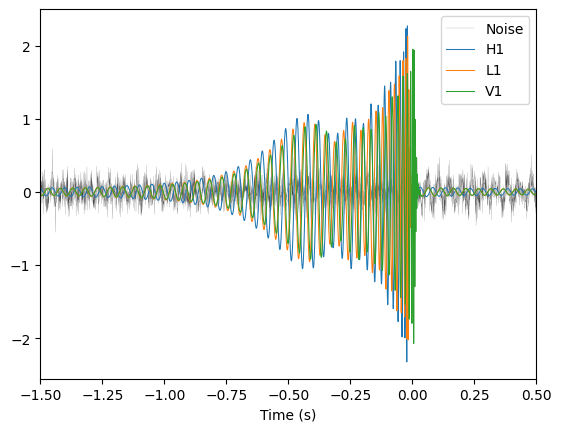

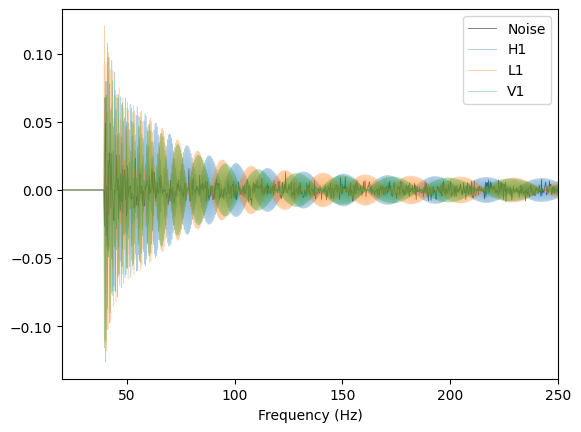

In [63]:
# Plot observation
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

tvals = np.linspace(-2, 2, 2048*4+1)[:-1]
fvals = np.linspace(20, 1024, 4098)[:-1]

plt.figure()
plt.plot(tvals, obs['n_t'][0], linewidth=0.1, alpha=0.8, label='Noise', color='k')
plt.plot(tvals, obs['d_t'][0], linewidth=0.75, label='H1')
plt.plot(tvals, obs['d_t'][1], linewidth=0.75, label='L1')
plt.plot(tvals, obs['d_t'][2], linewidth=0.75, label='V1')
plt.xlim(-1.5,0.5)
plt.xlabel('Time (s)')
plt.legend()

plt.show()

plt.figure()
plt.plot(fvals, obs['n_f'][0]*1e21, linewidth=0.5, alpha=0.7, label='Noise', color='k')
plt.plot(fvals, obs['d_f'][0]*1e21, linewidth=0.5, alpha=0.5, label='H1')
plt.plot(fvals, obs['d_f'][1]*1e21, linewidth=0.5, alpha=0.5, label='L1')
plt.plot(fvals, obs['d_f'][2]*1e21, linewidth=0.5, alpha=0.5, label='V1')
plt.xlim(20,250)
plt.xlabel('Frequency (Hz)')
plt.legend()

plt.show()

Now we plot the results of a simulation that has run previously

In [64]:
# Plot logratios

import pickle
import numpy as np
import zarr

round = 8

#obs_path = f'/scratch-shared/scur2012/peregrine_data/bhardwaj2023/observation_{run}'
#with open(obs_path, 'rb') as f:
#    obs = pickle.load(f)

# Prior
saved_path = f'/scratch-shared/scur2012/peregrine_data/bhardwaj2023/simulations_{run}_R{round}'
simulation_results = zarr.convenience.open(saved_path)

import pickle
# Posterior
logratio_path = f'/scratch-shared/scur2012/peregrine_data/bhardwaj2023/logratios_{run}/logratios_R{round-1}'

with open(logratio_path, 'rb') as f:
    logratio_data = pickle.load(f)
    


The following probability distributions show posteriors (blue) and priors (red) of the parameters as inferred using Bayesian inference (not shown here). The injected value (defined above) is shown as a black dotted line.

These plots are shown to demonstrate that the simulations can be run, neural network trained. However, it is difficult to show all of that in a Jupyter notebook. Hence, we just show the final result. The objective of the thesis will be to optimise the data analysis pipeline of these simulations.

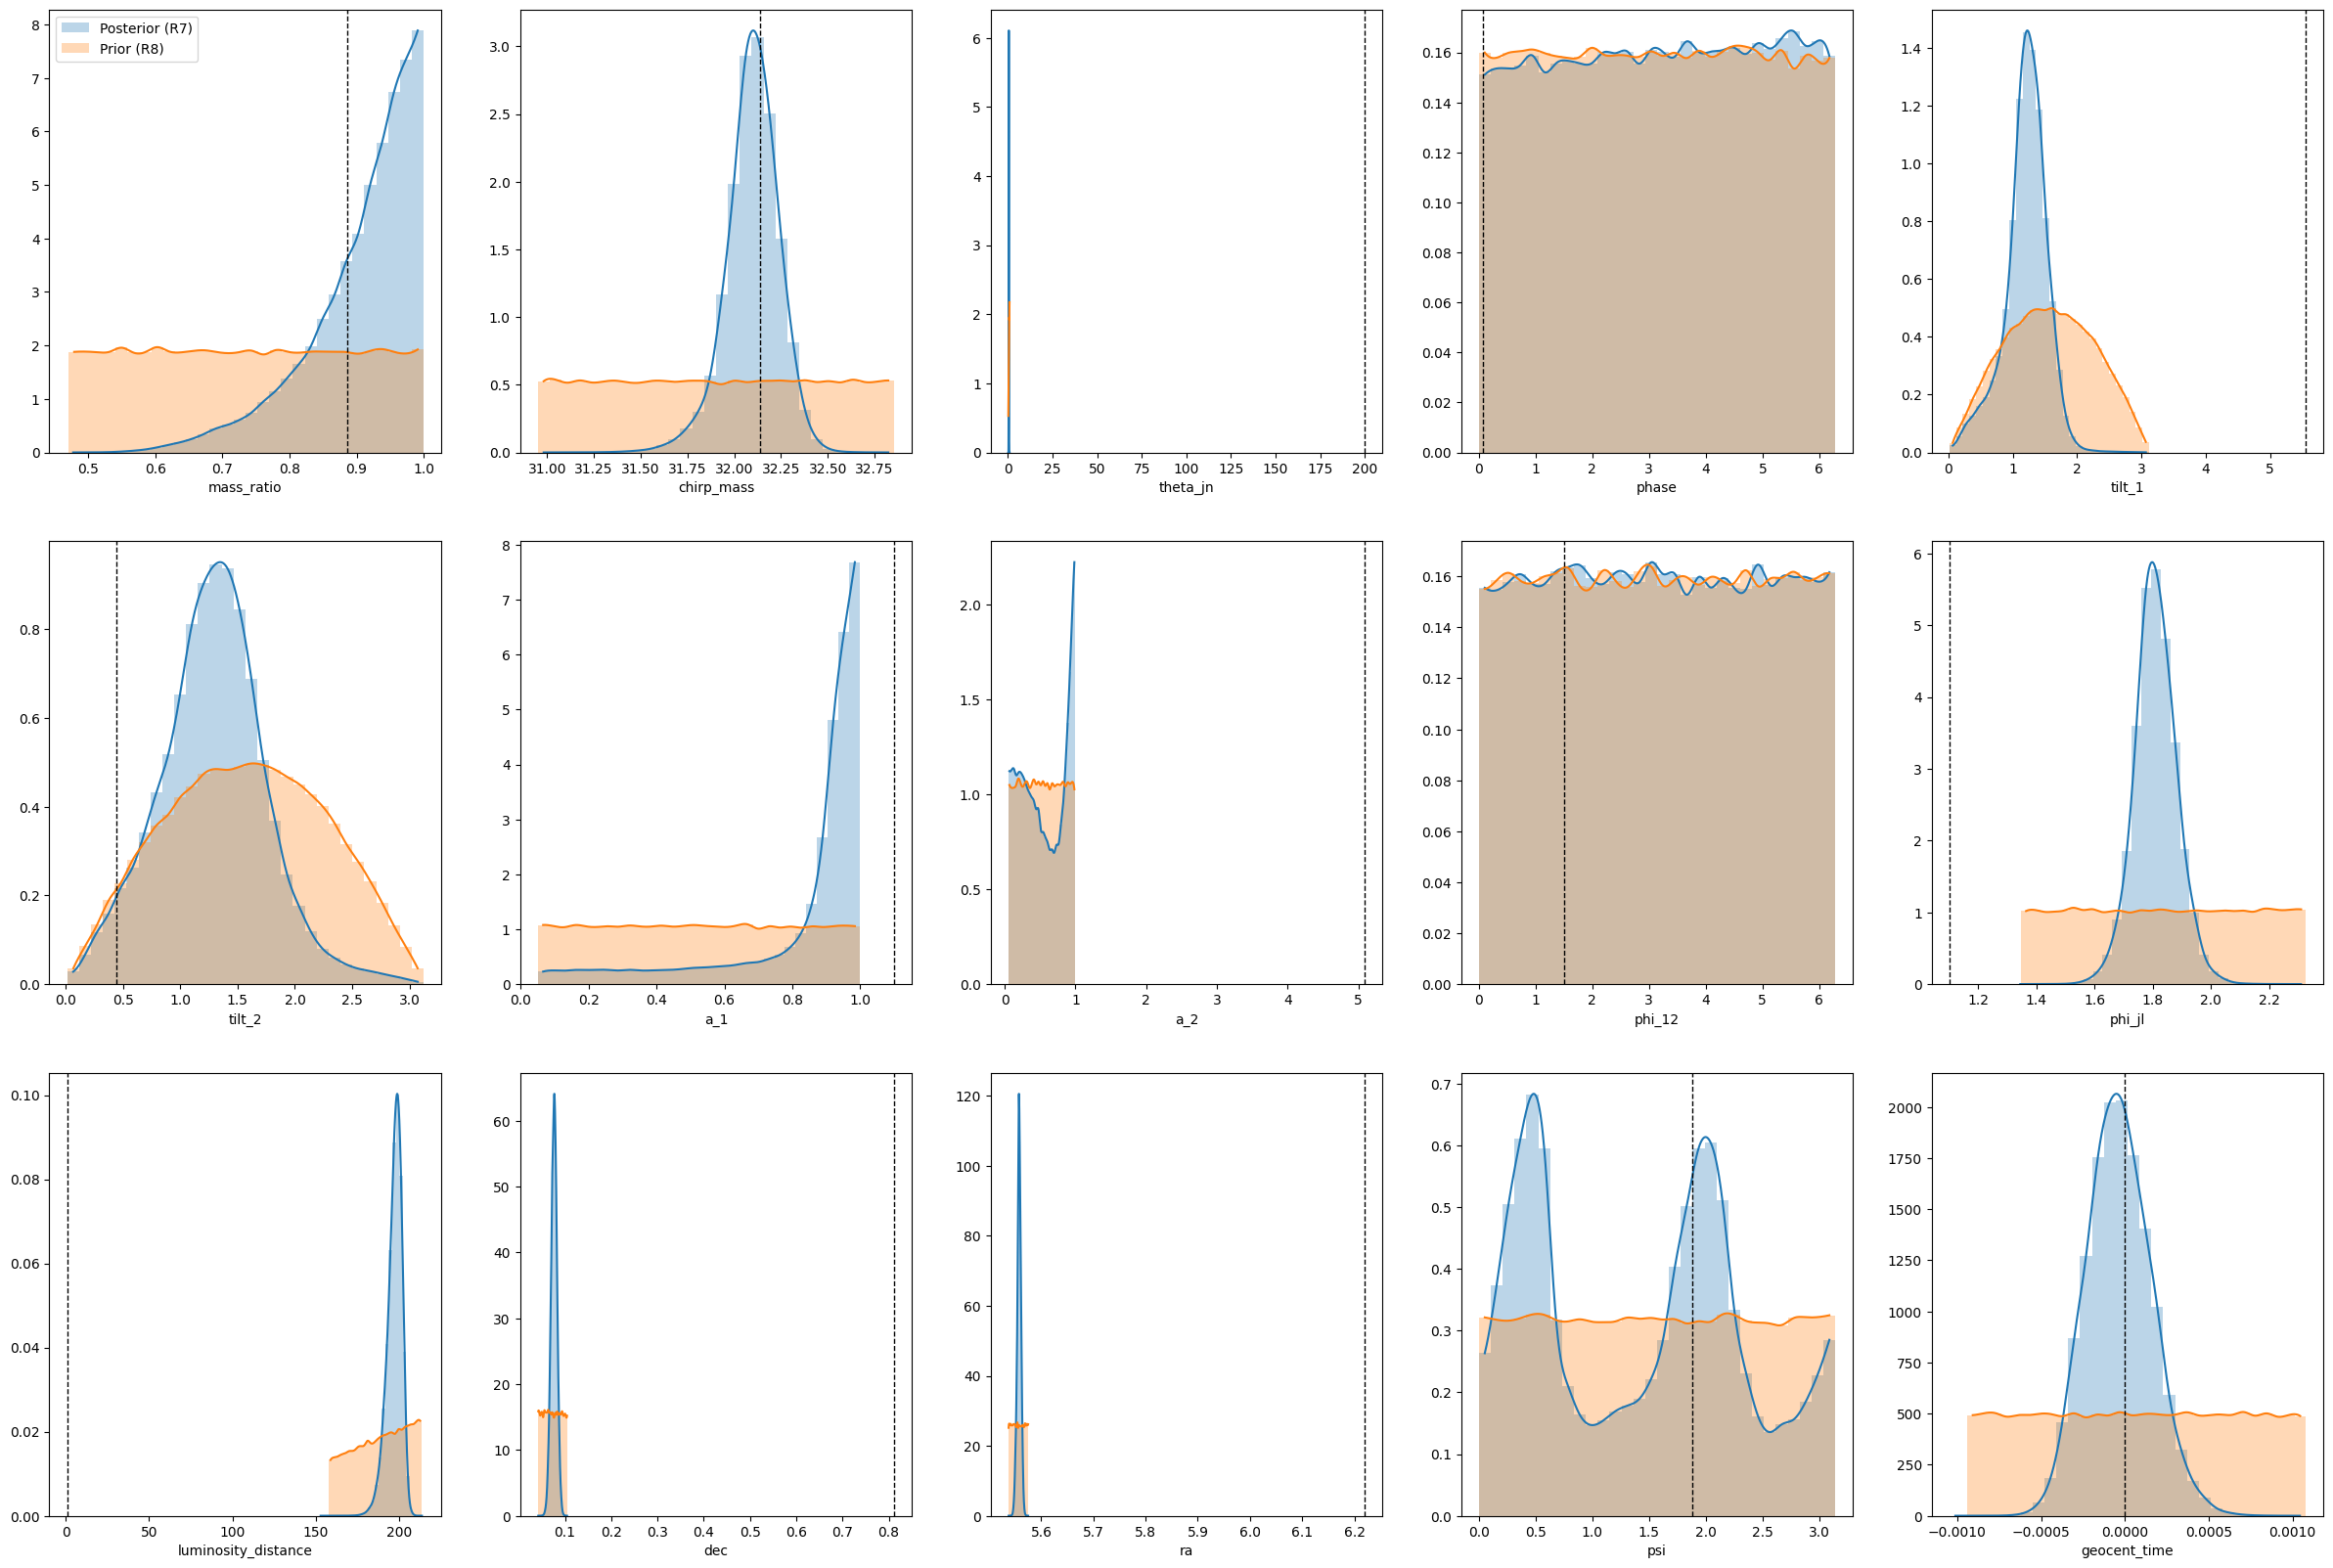

In [65]:
import pandas as pd
from scipy.interpolate import interp1d

parameter_names = pd.read_table(f'/scratch-shared/scur2012/peregrine_data/bhardwaj2023/param_idxs_{run}.txt', 
                                sep = '\s+', usecols=[0,1], header=None).set_index(1).values[:,0]
ground_truth = dict(zip(parameter_names, list(obs['z_int']) + list(obs['z_ext'])))

plt.figure(figsize=(30, 20))
for p_id in range(15):
    
    # Posteriors plot
    
    ax = plt.subplot(3, 5, p_id + 1)
    plt.xlabel(parameter_names[p_id])

    logratios = logratio_data.logratios[:, p_id]
    sample = logratio_data.params[:, p_id, 0]
    h, bins = np.histogram(
        sample, weights=np.exp(logratios), density=True, bins=30
    )
    bin_centres = 0.5 * (bins[1:] + bins[0:-1])
    plt.bar(
        bin_centres,
        h,
        width=bin_centres[1] - bin_centres[0],
        alpha=0.3,
        label=f'Posterior (R{round-1})',
    )
    min1, max1 = bin_centres[0], bin_centres[-1]
    fit1 = interp1d(bin_centres, h, kind=3, fill_value="extrapolate")

    x_grid = np.linspace(min1, max1, 1000)
    plt.plot(x_grid[fit1(x_grid)>0], fit1(x_grid)[fit1(x_grid)>0])
    
    # Priors plot
    
    #prob_masses = coverage_data.prob_masses[:, p_id]
    #sample = coverage_data.params[:, p_id, 0]
    
    sample = simulation_results['data']['z_total'][:, p_id]
        
    h, bins = np.histogram(
        sample, density=True, bins=30
    )
    bin_centres = 0.5 * (bins[1:] + bins[0:-1])
    plt.bar(
        bin_centres,
        h,
        width=bin_centres[1] - bin_centres[0],
        alpha=0.3,
        label=f'Prior (R{round})',
    )
    min1, max1 = bin_centres[0], bin_centres[-1]
    fit1 = interp1d(bin_centres, h, kind=3, fill_value="extrapolate")
    
    if p_id == 0:
        plt.legend()
    x_grid = np.linspace(min1, max1, 1000)
    plt.plot(x_grid[fit1(x_grid)>0], fit1(x_grid)[fit1(x_grid)>0])
    
    # Add ground-truth
    plt.axvline(ground_truth[parameter_names[p_id]], 0, 1, color='k', linestyle='--', linewidth=1)

plt.show()